In [1]:
%matplotlib inline
import json
import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import urllib, json

In [2]:
API_KEY = ''
meetup_group = 'central_london_data_science'
max_event_count = 100
max_per_page = 200

In [3]:
def get_json_from_meetup_api(url):
    full_url = url + '&key=' + API_KEY
    response = urllib.urlopen(full_url)
    return json.loads(response.read())

def get_members(group_name, offset = 0):
    print group_name, offset
    url = ('https://api.meetup.com/2/members?&sign=true&photo-host=public&group_urlname='
           +group_name
           +'&page='
           +str(max_per_page)
           +'&offset='
           +str(offset))
    return get_json_from_meetup_api(url)

def get_events(group_name):
    url = ('https://api.meetup.com/2/events?&sign=true&photo-host=public&group_urlname='
           +group_name
           +'&status=past,upcoming&page='
           +str(max_event_count))
    return get_json_from_meetup_api(url)

def get_group_info(group_name):
    url = 'https://api.meetup.com/'+group_name+'?&sign=true&photo-host=public'
    return get_json_from_meetup_api(url)

def get_all_members(group_name, count):
    loops = count/max_per_page
    extra_loop = count%max_per_page is not 0
    tota_loops = loops + extra_loop
    print (str(tota_loops) +' request(s) being made')
    store_members = []
    for i in range(tota_loops):
        current_get = get_members(group_name, offset = i)
        store_members += current_get['results']
    return store_members

def get_epoc_in_days_since(start_epoc, end_epoc):
    start = datetime.datetime.fromtimestamp(start_epoc/1000)
    end = datetime.datetime.fromtimestamp(end_epoc/1000)
    return (end - start).days

In [4]:
group_info = get_group_info(meetup_group)

In [5]:
group_start =  datetime.datetime.fromtimestamp(group_info['created']/1000)
group_start

datetime.datetime(2016, 4, 20, 2, 19, 11)

In [6]:
group_age = (datetime.datetime.now() -  group_start).days
group_age

248

In [7]:
group_info['members']

493

In [8]:
all_member_data = get_all_members(meetup_group, group_info['members'])

3 request(s) being made
central_london_data_science 0
central_london_data_science 1
central_london_data_science 2


In [9]:
len(all_member_data)

493

In [10]:
all_member_data[0]['joined']

1480437874000

In [11]:
group_info['members']

493

In [12]:
# get date joined in days resolution
dateJoined = [x["joined"]/1000 for x in all_member_data if 'joined' in x.keys()]

In [13]:
len(dateJoined)

492

In [14]:
epochs = sorted(dateJoined)
when_people_joined = [datetime.datetime.fromtimestamp(x) for x in epochs]

In [15]:
len(sorted(when_people_joined))

492

In [16]:
running_total_of_members = []
for i in range(group_age):
    sum_to_day = len([j for j in when_people_joined if (datetime.datetime.now()-j).days <= i])
    running_total_of_members.append(sum_to_day)

In [17]:
eventData = get_events(meetup_group)['results']

In [18]:
event_count = len(eventData)
event_count

17

In [19]:
create_event_date = [datetime.datetime.fromtimestamp(x['created']/1000) for x in eventData]
start_event_date = [datetime.datetime.fromtimestamp(x['time']/1000) for x in eventData]

create_event_day_from_group_start = [(x-group_start).days  for x in create_event_date]
start_event_day_from_group_start = [(x-group_start).days  for x in start_event_date]

len(create_event_day_from_group_start),len(start_event_day_from_group_start)

(17, 17)

## Plot members joined as events are anounced

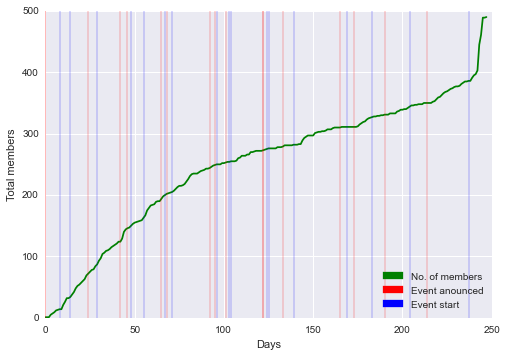

In [20]:
plt.plot(range(group_age),running_total_of_members,color='g')
for i in create_event_day_from_group_start:
    plt.axvline(x=i,color='r', linewidth=0.3)
for i in start_event_day_from_group_start:
    plt.axvline(x=i,color='b', linewidth=0.3)
members = mpatches.Patch(color='g', label='No. of members')
event_anounce = mpatches.Patch(color='r', label='Event anounced')
event_start = mpatches.Patch(color='b', label='Event start')

plt.legend(handles=[members,event_anounce,event_start],loc=4)
plt.xlabel('Days')
plt.ylabel('Total members')
plt.show()

## Plot members joined against event delay

In [21]:
event_member_gain = []
for e in eventData:
    member_gain = len([u for u in epochs if e['created'] < u*1000 < e['time'] ])
    event_member_gain.append({'gain':member_gain, 'event':e['name'], 'signup-duration':e['time']-e['created'] } )

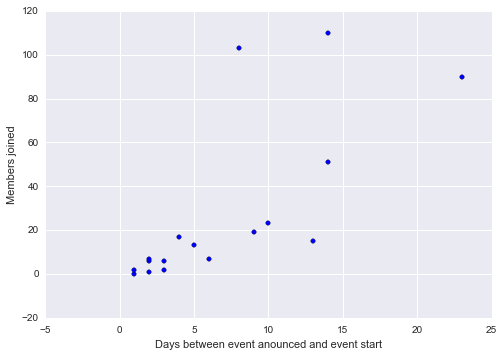

In [22]:
event_member_gain
plt.scatter([g['signup-duration']/1000/60/60/24 for g in event_member_gain],[g['gain'] for g in event_member_gain] )
plt.xlabel('Days between event anounced and event start')
plt.ylabel('Members joined')
plt.show()